In [1]:
import pandas as pd
import cobra
import copy
import time
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import scipy

ListOfRandomSpecies = [
'Bacteroides_thetaiotaomicron_VPI_5482',
'Bacteroides_sp_2_2_4',
'Parabacteroides_johnsonii_DSM_18315',
'Prevotella_oralis_ATCC_33269',
'Eubacterium_eligens_ATCC_27750',
'Slackia_exigua_ATCC_700122',
'Dorea_longicatena_DSM_13814',
'Clostridium_bartlettii_DSM_16795',
'Streptococcus_sp_I_P16',
'Blautia_hydrogenotrophica_DSM_10507',
'Brevundimonas_bacteroides_DSM_4726',
'Clostridium_hylemonae_DSM_15053',
'Sutterella_wadsworthensis_3_1_45B',
'Enterobacteriaceae_bacterium_9_2_54FAA',
'Bacillus_megaterium_DSM319',
#'Peptostreptococcus_stomatis_DSM_17678', # average-european-diet causes problems
'Brachybacterium_paraconglomeratum_LC44',
'Neisseria_elongata_subsp_glycolytica_ATCC_29315',
'Rothia_aeria_F0474',
'Staphylococcus_hominis_subsp_hominis_C80', 
]

betternames = [n.split('_')[0][0] + '.' + n.split('_')[1] for n in ListOfRandomSpecies]
stats = {}
types = [
    'high-fiber-diet',
    'unconstrained',
    'western-diet',
    'average-european-diet',
 
]

def sensitivitySort(DietSensitivity):
    metnames=['']
    metsensitivity=[0]
    check=0
    for metabolite in DietSensitivity.keys():
        if check == 0:
            check+=1
            metnames[0]=metabolite
            metsensitivity[0]=DietSensitivity[metabolite]
        else:
            i=0
            while i<len(metnames):
                if DietSensitivity[metabolite] >  metsensitivity[i]:
                    metsensitivity[i+1:]=metsensitivity[i:]
                    metsensitivity[i]= DietSensitivity[metabolite]
                    metnames[i+1:]=metnames[i:]
                    metnames[i]=metabolite
                    break
                elif i==len(metnames)-1:
                    metsensitivity.append(DietSensitivity[metabolite])
                    metnames.append(metabolite)
                    break
                i+=1
    return metnames, metsensitivity

def getRelevantDictionaries(diet, species):
    model = cobra.io.read_sbml_model("./dfba/data/"+ diet +"/" + species + ".xml")
    AllExchanges = [r.id for r in model.exchanges]
    solution = model.optimize()
    igr = solution.objective_value
    DietSensitivity = {}
    originallb = {}
    for r in AllExchanges:
        if r not in DietSensitivity.keys():
            originallb[r] = model.reactions.get_by_id(r).lower_bound
            model.reactions.get_by_id(r).lower_bound = 0
            s = model.optimize()
            gr = s.objective_value
            DietSensitivity[r] = abs(igr-gr)/igr
            model.reactions.get_by_id(r).lower_bound = originallb[r] 
    return model, DietSensitivity, originallb

def getMinMetabolites(diet,species,SenThresh,Clusters=False):
    model, DietSensitivity, originallb = getRelevantDictionaries(diet, species)
    metnames, metsensitivity = sensitivitySort(DietSensitivity)
    s = model.optimize()
    gro = s.objective_value
    EssentialMetabolites = {}
    NonEssentialMetabolites = {}
    for i in range(len(metnames)-1,-1,-1):
#         s = model.optimize()
#         gri = s.objective_value
        model.reactions.get_by_id(metnames[i]).lower_bound = 0
        s = model.optimize()
        gr = s.objective_value
        Sens = abs(gro-gr)/gro
        if Sens > SenThresh: #if essential
            EssentialMetabolites[metnames[i]]=Sens
            model.reactions.get_by_id(metnames[i]).lower_bound = originallb[metnames[i]]
        elif originallb[metnames[i]] < 0:
            NonEssentialMetabolites[metnames[i]]=Sens
    if Clusters== False:
        return EssentialMetabolites, NonEssentialMetabolites
    else:
        return  model, DietSensitivity, originallb, EssentialMetabolites, NonEssentialMetabolites
    
def findGrowthRates(MinMetabolites, diet, species):
    model = cobra.io.read_sbml_model("./dfba/data/"+ diet +"/" + species + ".xml")
    AllExchanges = [r.id for r in model.exchanges]
    OptimalSolution = model.optimize()
    OptimalGrowth = OptimalSolution.objective_value
    for r in AllExchanges:
        if r not in MinMetabolites:
            model.reactions.get_by_id(r).lower_bound = 0.0
    MinSolution = model.optimize()
    MinMetaboliteGrowth = OptimalSolution.objective_value
    return OptimalGrowth, MinMetaboliteGrowth

def getExcretedMetabolites(model):
    AllExchanges = [r.id for r in model.exchanges]
    MinSolution = model.optimize()
    ExcretedMetabolites = []
    for r in AllExchanges:
        if MinSolution.fluxes[r] > 0:
            ExcretedMetabolites.append(r)
    return ExcretedMetabolites

def defineClusters(diet,species,SenThresh):
#     start=time.clock()
#     print('Clustering Now...'
    model, DietSensitivity, originallb, EssentialMetabolites, NonEssentialMetabolites = getMinMetabolites(diet,species,SenThresh,True)
    newclocktime = time.clock()
#     print('Time for MinMet =' + str(newclocktime-start))
    print(species + ' has ' + str(len(EssentialMetabolites)) + ' essential metabolites')
    print('\tand ' + str(len(NonEssentialMetabolites)) + ' non-essential metabolites')
    s = model.optimize()
    gro = s.objective_value
    Clusters = {}
    ExcretedMetabolites = getExcretedMetabolites(model)
    UniqueMetabolites = []
    for cluster in EssentialMetabolites:
        ClusterStorage = [cluster]
        model.reactions.get_by_id(cluster).lower_bound = 0
        s = model.optimize()
        kogr = s.objective_value
        ExcretionSame = 'Yes'
        NewExcretedMetabolites = ExcretedMetabolites
        for metabolite in NonEssentialMetabolites:
            model.reactions.get_by_id(metabolite).lower_bound = originallb[metabolite]        
            s = model.optimize()
            metgr = s.objective_value
            if (metgr-kogr)/(gro-kogr) >= SenThresh*0.99:
                ClusterStorage.append(metabolite)
                NewExcretedMetabolites = getExcretedMetabolites(model)
                ExcretedMetabolites, NonOverlap = getMetabolicOutputOverlap(ExcretedMetabolites,NewExcretedMetabolites)
                UniqueMetabolites = set(UniqueMetabolites) | NonOverlap
                CombinedExcretion = ExcretedMetabolites | UniqueMetabolites
                if len(list(CombinedExcretion)) != len(list(ExcretedMetabolites)) or  len(ExcretedMetabolites) != len(NewExcretedMetabolites):
                    ExcretionSame = 'No'
            model.reactions.get_by_id(metabolite).lower_bound = 0   
        Clusters[cluster] = {'ClusterMetabolites':ClusterStorage,'SharedMetabolites': ExcretedMetabolites, 'UniqueMetabolites':UniqueMetabolites, 'ExcretionTheSame': ExcretionSame}
        model.reactions.get_by_id(cluster).lower_bound = originallb[cluster]   
#     print('ClusterTime =' + str(time.clock()-newclocktime))
    return Clusters

def cleanupname(name):
    """
     The reaction names in the model files 
     don't have brackets or parentheses. I replaced
     those found in the mediaFluxes file.
     """
    name = name.replace('[', '__40__')#_LPAREN_')
    name = name.replace(']', '__41__')#'_RPAREN_')
    name = name.replace('(', '__40__')#'_LPAREN_')
    name = name.replace(')', '__41__')#'_RPAREN_')
    return name


def unsatisfiedClusters(Clusters,dietSet):
    A = set()
    B = set()
    for metabolite in dietSet:
        for clust in Clusters.keys():
            B.add(clust)
            if metabolite in Clusters[clust]['ClusterMetabolites']:
                A.add(clust)
    return B-A

def requiredNutrients(CommunitySpecies, CommunityType, dietFile, RemoveOutExchanges=False):
    AllEssentialMetabolites = set()
    dietSet = set()
    for i, row in dietFile.iterrows():
        N = cleanupname(row.Reaction)
        dietSet.add(N)
    for species in CommunitySpecies:
        print(species)
        model, DietSensitivity, originallb, EssentialMetabolites, NonEssentialMetabolites = getMinMetabolites(CommunityType,species,0.99,Clusters=True)
        excreted = set()
        if RemoveOutExchanges == True:
            for r in originallb.keys():
                if originallb[r] >=0:
                    excreted.add(r)
        AllEssentialMetabolites = (AllEssentialMetabolites | set(EssentialMetabolites))-excreted
    Overlap,ClusterSetMissed= getMetabolicOutputOverlap(dietSet,AllEssentialMetabolites)
    return ClusterSetMissed
  
    
    
def getMetabolicOutputOverlap(ClusterA, ClusterB):
    A = set(ClusterA)
    B = set(ClusterB)
    Overlap =  A & B
    Unique = (A-B) | (B-A)
    return Overlap, Unique


In [2]:
# for i in ListofRandomSpecies:
#     Communtiy = ListofRandomSpecies[i]
#     break
Community = ListOfRandomSpecies
dietFile = pd.read_csv('./dfba/data/diet-definitions/VMH_HighFiber.tsv', sep='\t')
ClustersMissed = requiredNutrients(Community,'average-european-diet',dietFile,False)
print(ClustersMissed)

Bacteroides_thetaiotaomicron_VPI_5482
Bacteroides_sp_2_2_4
Parabacteroides_johnsonii_DSM_18315
Prevotella_oralis_ATCC_33269
Eubacterium_eligens_ATCC_27750
Slackia_exigua_ATCC_700122
Dorea_longicatena_DSM_13814
Clostridium_bartlettii_DSM_16795
Streptococcus_sp_I_P16
Blautia_hydrogenotrophica_DSM_10507
Brevundimonas_bacteroides_DSM_4726
Clostridium_hylemonae_DSM_15053
Sutterella_wadsworthensis_3_1_45B
Enterobacteriaceae_bacterium_9_2_54FAA
Bacillus_megaterium_DSM319
Brachybacterium_paraconglomeratum_LC44
Neisseria_elongata_subsp_glycolytica_ATCC_29315
Rothia_aeria_F0474
Staphylococcus_hominis_subsp_hominis_C80
{'EX_hpdca__40__e__41__', 'EX_chsterol__40__e__41__', 'EX_dgchol__40__e__41__', 'EX_hdca__40__e__41__', 'EX_urate__40__e__41__', 'EX_ddca__40__e__41__', 'EX_12dgr180__40__e__41__', 'EX_docosac__40__e__41__', 'EX_dcyt__40__e__41__', 'EX_ocdcea__40__e__41__', 'EX_lcts__40__e__41__', 'EX_adn__40__e__41__', 'EX_dgsn__40__e__41__', 'EX_gln_L__40__e__41__', 'EX_hdcea__40__e__41__', 'EX_x

In [59]:
OverlapDict = {}
ClusterSizeStorage = []
AverageNumberOfClusters = []

for sp in ListOfRandomSpecies:
    if 'Peptostreptococcus' in sp:
        continue
    else:
        Clusters = defineClusters('average-european-diet',sp,0.99)
        anything=0
        for A in Clusters.keys():
            if len(Clusters[A]['ClusterMetabolites']) > 1:
                anything += 1
                ClusterSizeStorage.append(len(Clusters[A]['ClusterMetabolites']))
                print('\tCluster ' + str(anything) + ' = ' + str(Clusters[A]['ClusterMetabolites']))
                print('\tMetabolic excretion the same?   ' + Clusters[A]['ExcretionTheSame'] )
                print('\tOverlapping excreted metabolites =' + str(len(Clusters[A]['SharedMetabolites'])))
                print('\tUnique excreted metabolites =' + str(len(Clusters[A]['UniqueMetabolites'])))
                OverlapDict[sp + '_Cluster_' + str(anything)] = len(Clusters[A]['SharedMetabolites'])/(len(Clusters[A]['SharedMetabolites'])+len(Clusters[A]['UniqueMetabolites']))
        AverageNumberOfClusters.append(anything)
        if anything==0:
            print('\tand no clusters have size > 1')

# objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
# y_pos = np.arange(len(objects))
# performance = [10,8,6,4,2,1]
# plt.bar(y_pos, performance, align='center', alpha=0.5)

# plotthis = {sp:stats[sp][t] for sp in stats.keys()}
# plt.bar([r + pos for r in range(len(plotthis))], plotthis.values(),width=0.15, align='center', label=t)


Bacteroides_thetaiotaomicron_VPI_5482 has 18 essential metabolites
	and 51 non-essential metabolites
	Cluster 1 = ['EX_h2o__40__e__41__', 'EX_fru__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_sucr__40__e__41__']
	Metabolic excretion the same?   No
	Overlapping excreted metabolites =9
	Unique excreted metabolites =11
Bacteroides_sp_2_2_4 has 15 essential metabolites
	and 47 non-essential metabolites
	and no clusters have size > 1
Parabacteroides_johnsonii_DSM_18315 has 17 essential metabolites
	and 55 non-essential metabolites
	Cluster 1 = ['EX_h2o__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_adn__40__e__41__', 'EX_xyl_D__40__e__41__', 'EX_sucr__40__e__41__']
	Metabolic excretion the same?   No
	Overlapping excreted metabolites =8
	Unique excreted metabolites =5
	Cluster 2 = ['EX_glyc__40__e__41__', 'EX_thr_L__40__e__41__', 'EX_malt__40__e__41__', 'EX_lcts__40__e__41__', 'EX_adn__40__e__41__', 'EX_12dgr180__40__e__41__', 'EX_xyl_D__40__e__41__'

	Unique excreted metabolites =17
	Cluster 5 = ['EX_gua__40__e__41__', 'EX_xan__40__e__41__', 'EX_dgsn__40__e__41__']
	Metabolic excretion the same?   No
	Overlapping excreted metabolites =9
	Unique excreted metabolites =17
	Cluster 6 = ['EX_arg_L__40__e__41__', 'EX_orn__40__e__41__']
	Metabolic excretion the same?   No
	Overlapping excreted metabolites =9
	Unique excreted metabolites =19


Average overlap within metabolic cluster = 0.5245270963088028


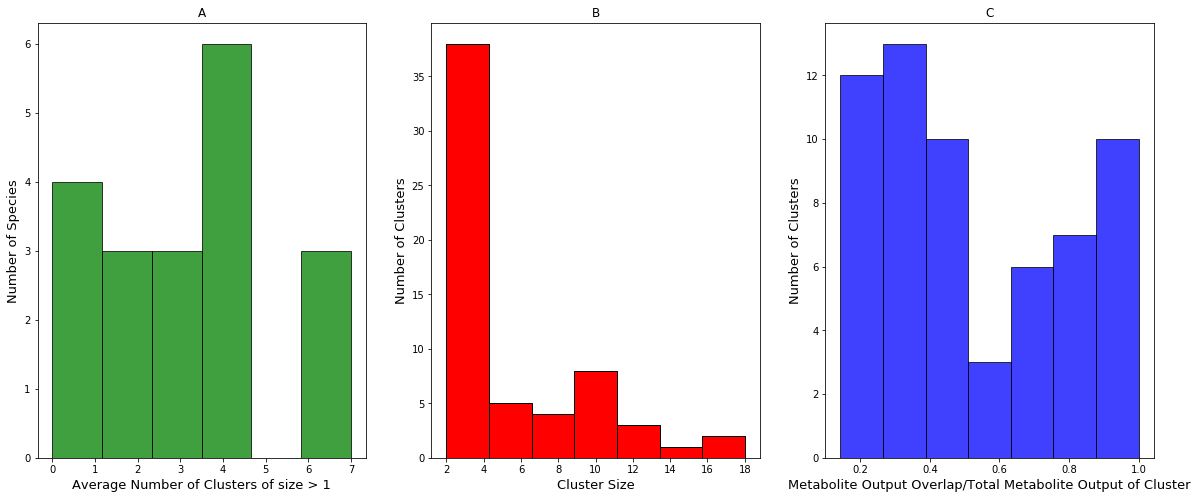

In [78]:
f,ax = plt.subplots(1,3,figsize=(20, 8))

dataset =  [OverlapDict[clust] for clust in OverlapDict.keys()]
num_bins = 8
ax[2].hist(dataset, bins='auto', facecolor='blue', edgecolor = 'black', alpha = 0.75)
ax[2].set_xlabel('Metabolite Output Overlap/Total Metabolite Output of Cluster', fontsize = 13)
ax[2].set_ylabel('Number of Clusters', fontsize = 13)
ax[2].set_title('C')


print('Average overlap within metabolic cluster = ' + str(scipy.mean(dataset)))

# ClusterSizeStorage = []
# AverageNumberOfClusters = []
dataset =  ClusterSizeStorage
ax[1].hist(dataset, bins='auto', facecolor='red', edgecolor = 'black')
ax[1].set_xlabel('Cluster Size', fontsize = 13)
ax[1].set_ylabel('Number of Clusters', fontsize = 13)
ax[1].set_title('B')


dataset =  AverageNumberOfClusters
ax[0].hist(dataset, bins='auto', facecolor='green', edgecolor = 'black', alpha=0.75)
ax[0].set_xlabel('Average Number of Clusters of size > 1', fontsize = 13)
ax[0].set_ylabel('Number of Species', fontsize = 13)
ax[0].set_title('A')

plt.show()


In [2]:
import pandas as pd
import cobra
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


ListOfRandomSpecies = [
'Bacteroides_thetaiotaomicron_VPI_5482',
'Bacteroides_sp_2_2_4',
'Parabacteroides_johnsonii_DSM_18315',
'Prevotella_oralis_ATCC_33269',
'Eubacterium_eligens_ATCC_27750',
'Slackia_exigua_ATCC_700122',
'Dorea_longicatena_DSM_13814',
'Clostridium_bartlettii_DSM_16795',
'Streptococcus_sp_I_P16',
'Blautia_hydrogenotrophica_DSM_10507',
'Brevundimonas_bacteroides_DSM_4726',
'Clostridium_hylemonae_DSM_15053',
'Sutterella_wadsworthensis_3_1_45B',
'Enterobacteriaceae_bacterium_9_2_54FAA',
'Bacillus_megaterium_DSM319',
#'Peptostreptococcus_stomatis_DSM_17678', # average-european-diet causes problems
'Brachybacterium_paraconglomeratum_LC44',
'Neisseria_elongata_subsp_glycolytica_ATCC_29315',
'Rothia_aeria_F0474',
'Staphylococcus_hominis_subsp_hominis_C80', 
]

betternames = [n.split('_')[0][0] + '.' + n.split('_')[1] for n in ListOfRandomSpecies]
stats = {}
types = [
    'high-fiber-diet',
   'unconstrained',
    'western-diet',
    'average-european-diet',
 
]
for t in types:
    print(t)
    for sp in ListOfRandomSpecies:
        if 'Peptostreptococcus' in sp and t=='average-european-diet':
            continue
        else:
            if sp not in stats.keys():
                stats[sp] = {}
            print(sp)
            EssentialMetabolites, NonEssentialMetabolites = getMinMetabolites(t,sp,0.75)
            OptimalGrowth, MinMetaboliteGrowth = findGrowthRates(EssentialMetabolites, t, sp)

            print("\tOptimal growth rate:" + str(OptimalGrowth))
            print("\tWith minimal nutrient set: " + str(MinMetaboliteGrowth))
            print("\tThe minimal set contains " + str(len(EssentialMetabolites)) + " metabolites")
    
            stats[sp][t]=len(EssentialMetabolites)
            

 

high-fiber-diet
Bacteroides_thetaiotaomicron_VPI_5482
	Optimal growth rate:0.48339434718146623
	With minimal nutrient set: 0.48339434718146623
	The minimal set contains 19 metabolites
Bacteroides_sp_2_2_4
	Optimal growth rate:0.16784884732092825
	With minimal nutrient set: 0.16784884732092825
	The minimal set contains 14 metabolites
Parabacteroides_johnsonii_DSM_18315
	Optimal growth rate:0.1612776487048265
	With minimal nutrient set: 0.1612776487048265
	The minimal set contains 15 metabolites
Prevotella_oralis_ATCC_33269
	Optimal growth rate:0.22881931949942072
	With minimal nutrient set: 0.22881931949942072
	The minimal set contains 42 metabolites
Eubacterium_eligens_ATCC_27750
	Optimal growth rate:0.12779952020945626
	With minimal nutrient set: 0.12779952020945626
	The minimal set contains 29 metabolites
Slackia_exigua_ATCC_700122
	Optimal growth rate:0.027461437183255534
	With minimal nutrient set: 0.027461437183255534
	The minimal set contains 35 metabolites
Dorea_longicatena_DSM_

	The minimal set contains 22 metabolites
Enterobacteriaceae_bacterium_9_2_54FAA
	Optimal growth rate:0.5334493712619871
	With minimal nutrient set: 0.5334493712619871
	The minimal set contains 14 metabolites
Bacillus_megaterium_DSM319
	Optimal growth rate:0.41120744655579494
	With minimal nutrient set: 0.41120744655579494
	The minimal set contains 22 metabolites
Brachybacterium_paraconglomeratum_LC44
	Optimal growth rate:0.4375586689291365
	With minimal nutrient set: 0.4375586689291365
	The minimal set contains 23 metabolites
Neisseria_elongata_subsp_glycolytica_ATCC_29315
	Optimal growth rate:0.06779646679442973
	With minimal nutrient set: 0.06779646679442973
	The minimal set contains 27 metabolites
Rothia_aeria_F0474
	Optimal growth rate:0.11679880105248013
	With minimal nutrient set: 0.11679880105248013
	The minimal set contains 31 metabolites
Staphylococcus_hominis_subsp_hominis_C80
	Optimal growth rate:0.2569873646672939
	With minimal nutrient set: 0.2569873646672939
	The minimal 

Bacteroides_thetaiotaomicron_VPI_5482	19	16	18
Bacteroides_sp_2_2_4	14	14	14
Parabacteroides_johnsonii_DSM_18315	15	15	15
Prevotella_oralis_ATCC_33269	42	27	27
Eubacterium_eligens_ATCC_27750	29	29	30
Slackia_exigua_ATCC_700122	35	35	35
Dorea_longicatena_DSM_13814	16	16	17
Clostridium_bartlettii_DSM_16795	23	21	22
Streptococcus_sp_I_P16	27	28	28
Blautia_hydrogenotrophica_DSM_10507	19	18	19
Brevundimonas_bacteroides_DSM_4726	27	25	25
Clostridium_hylemonae_DSM_15053	20	19	20
Sutterella_wadsworthensis_3_1_45B	23	22	22
Enterobacteriaceae_bacterium_9_2_54FAA	14	12	14
Bacillus_megaterium_DSM319	23	23	22
Brachybacterium_paraconglomeratum_LC44	24	21	23
Neisseria_elongata_subsp_glycolytica_ATCC_29315	27	27	27
Rothia_aeria_F0474	30	29	31
Staphylococcus_hominis_subsp_hominis_C80	26	27	27


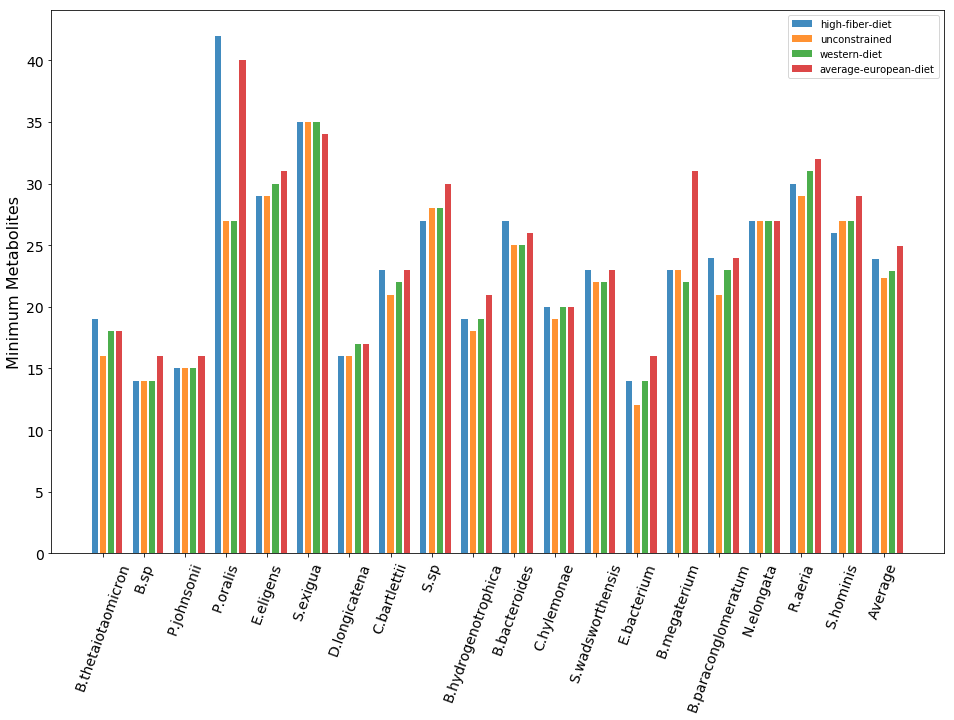

In [7]:
#del stats['Peptostreptococcus_stomatis_DSM_17678']
for s in stats:
    if 'Peptostreptococcus' not in s:
        print(s + '\t' + str(stats[s][types[0]]) + '\t' +  str(stats[s][types[1]]) + '\t' +  str(stats[s][types[2]]))


pos = -0.2
plt.figure(figsize=(16,10))
for t in types:
    plotthis = {sp:stats[sp][t] for sp in stats.keys()}
    dataset =  [stats[sp][t] for sp in stats.keys()]
    plotthis['Average'] = scipy.mean(dataset)
    plt.bar([r + pos for r in range(len(plotthis))], plotthis.values(),width=0.15, align='center', label=t, alpha = 0.85)
    pos +=0.2
    betternames.append( 'Average')
plt.xticks(range(len(plotthis)), betternames,rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Minimum Metabolites', fontsize=16)
plt.legend()
plt.show()
            

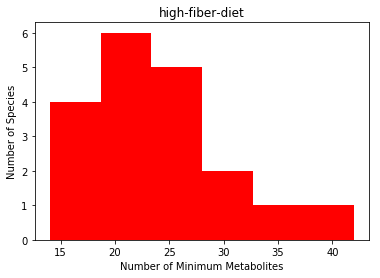

Average number of min metabolites  = 23.842105263157894


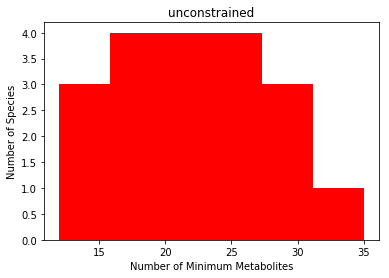

Average number of min metabolites  = 22.31578947368421


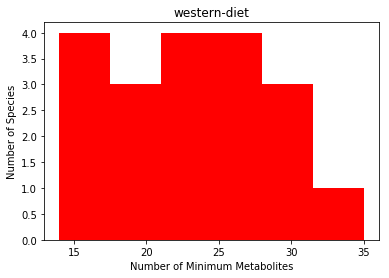

Average number of min metabolites  = 22.94736842105263


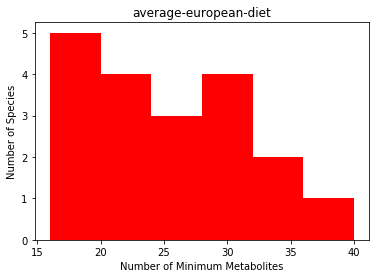

Average number of min metabolites  = 24.94736842105263


In [4]:
for t in types:
    dataset =  [stats[sp][t] for sp in stats.keys()]
    num_bins = 8
    n, bins, patches = plt.hist(dataset, bins='auto', facecolor='red')
    plt.xlabel('Number of Minimum Metabolites')
    plt.ylabel('Number of Species')
    plt.title(t)
    plt.show()
    print('Average number of min metabolites  = ' + str(scipy.mean(dataset)))

#plt.legend()
    
